# Loading Libraries




In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
np.warnings.filterwarnings('ignore')

In [2]:
gc.enable()

train = pd.read_csv('../input/training_set.csv')

# Features to compute with tsfresh library. Fft coefficient is meant to capture periodicity
fcp = {'fft_coefficient': [{'coeff': 0, 'attr': 'abs'},{'coeff': 1, 'attr': 'abs'}],
#                           {'coeff': 2, 'attr': 'abs'},{'coeff': 3, 'attr': 'abs'}],
        'kurtosis' : None, 'skewness' : None,
        'maximum':None, 'minimum':None, 'mean':None,
       'sample_entropy':None,'sum_values':None,'longest_strike_above_mean':None,
    'length':None, 'longest_strike_below_mean':None,}
flux_dic={ 'longest_strike_above_mean':None, 'length':None }

flux_by_flux_dict={'longest_strike_above_mean': None,
            'longest_strike_below_mean': None, 'kurtosis' : None,  'mean_change': None,
          'mean_abs_change': None  }



def featurize(df):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']


    aggs = {
        'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
        'detected': ['mean'],
        'flux_ratio_sq':['sum','skew'],
        'flux_by_flux_ratio_sq':['sum','skew'],
    }

    agg_df = df.groupby(['object_id']).agg(aggs)
    new_columns = [
        k + '_' + agg for k in aggs.keys() for agg in aggs[k]
    ]
    agg_df.columns = new_columns
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']

    agg_df['flux_dif2'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_sum'] / agg_df['flux_ratio_sq_sum']
    agg_df['flux_dif3'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']
    agg_df_ts = extract_features(df, column_id='object_id', column_sort='mjd', column_kind='passband', column_value = 'flux', default_fc_parameters = fcp, n_jobs=4)
    df_det = df[df['detected']==1].copy()
    agg_df_mjd = extract_features(df_det, column_id='object_id', column_value = 'mjd', default_fc_parameters = {'maximum':None, 'minimum':None}, n_jobs=4)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd['mjd__minimum']
    
    
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd, on = 'id')
    
    agg_flux_d=extract_features(df, column_id='object_id',column_value='flux',default_fc_parameters=flux_dic, n_jobs=4)
    #agg_flux_by_d=extract_features(df, column_id='object_id',column_value='flux_by_flux_ratio_sq',default_fc_parameters=flux_by_flux_dict, n_jobs=4)
    agg_flux_d.index.rename('object_id', inplace=True)
    #agg_flux_by_d.index.rename('object_id', inplace=True)
    agg_df_ts.index.rename('object_id',inplace=True)
    agg_df_tss=pd.concat([agg_flux_d, agg_df_ts], axis=1)
    maxtime=df.loc[df.groupby(['object_id'])["flux"].idxmax()]['mjd']
    mintime=df.loc[df.groupby(['object_id'])["flux"].idxmin()]['mjd']
    agg_df['time_dif']=maxtime.values-mintime.values
    agg_df = pd.merge(agg_df, agg_df_tss, on='object_id')
    
    return agg_df

agg_train = featurize(train)

Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 11.88it/s]


# Merging features with meta data

In [3]:
meta_train = pd.read_csv('../input/training_set_metadata.csv')
meta_train.head()
#######Add new features
def add_feat(df):
    df['photoz_ratio_sq'] = np.power(df['hostgal_photoz'] / df['hostgal_photoz_err'], 2.0)
    df['photoz_by_photoz_ratio_sq'] = df['hostgal_photoz'] * df['photoz_ratio_sq']
    return df

meta_train=add_feat(meta_train)

full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='left',
    on='object_id'
)

def add_new(df):

    df['mjd_photoz_ratio']=(df['mjd_diff_det']/df['hostgal_photoz'].max())
    df['distmod_rt']=(df['mjd_diff_det']/(df['distmod']))
    
    df['photo_distmod']=(df['distmod']/(df['hostgal_photoz']))
    df['distmod_median']=np.power(df['distmod']-df['flux_median'],2)#

    df['photoz_flux']=df['hostgal_photoz']+df['flux_skew']
    df['mwebv_flux']=(df['mwebv']+df['flux_max']).abs()/(df['mjd_diff_det'])#
    df['flux_all']=df['flux_max'].max()-df['flux_max']/(df['flux_mean'])
    df['mwebv_hostgal']=(df['mwebv']+df['flux_mean']).abs()/(df['mjd_diff_det'])#

    df['dist_ch']=(df['distmod'].mean()-df['distmod']).abs()
    df['dist_cm']=(df['distmod'].max()-df['distmod'])###new important
    df['distmod_rtm']=(df['mjd_diff_det']/(df['dist_ch']))

    df['host_minmean']=(df['hostgal_photoz'].mean()-df['hostgal_photoz'])
    df['host_max_mi']=(df['hostgal_photoz'].max()-df['hostgal_photoz'])

            
        ##Features for passbands
    for i in range(6):
        df['qshift2_'+str(i)]=((df['flux_max'])-(df[str(i)+'__maximum']))/(df['flux_mean'])
        df['apshift2_'+str(i)]=((df['flux_max'])-(df['flux_min']))/(((df[str(i)+'__maximum'])-(df[str(i)+'__minimum'])))
        df['6mb'+str(i)]=(df['flux_mean']-df[str(i)+'__mean'])/(df['flux_mean'])
        df['6mmb'+str(i)]=(df['flux_max']-df[str(i)+'__maximum'])/(df['flux_max'])
    
    
    for i in range(6):
        for j in range(i+1,6):
            df['Pass'+str(i)+'max_sub_pass'+str(j)+'max']=(df[str(i)+'__maximum']-df[str(j)+'__maximum'])/(df['flux_max'])
            df['Pass'+str(i)+'mean_sub_pass'+str(j)+'mean']=(df[str(i)+'__mean']-df[str(j)+'__mean'])/(df['flux_mean'])
            df['Pass'+str(i)+'max_sub_pass'+str(j)+'max_Dmean']=(df[str(i)+'__maximum']-df[str(j)+'__maximum'])/(df['flux_mean'])
            df['Pass'+str(i)+'mean_sub_pass'+str(j)+'mean_Dmax']=(df[str(i)+'__mean']-df[str(j)+'__mean'])/(df['flux_max'])
  
    df['time_dif']=df['time_dif'].abs()
    
    for i in range(6):
        df['Pass'+str(i)+'_mult_ELM']=((df[str(i)+'__sample_entropy'])*(df[str(i)+'__longest_strike_above_mean'])*df[str(i)+'__mean'])
        df['Max_sub_Pass'+str(i)+'max_Dstd']=((df['flux_max'])-(df[str(i)+'__maximum']))/(df['flux_std'])

    
   
    del df['0__maximum'],df['1__maximum'],df['2__maximum'],df['3__maximum'],df['4__maximum'],df['5__maximum']
    del df['0__minimum'],df['1__minimum'],df['2__minimum'],df['3__minimum'],df['4__minimum'],df['5__minimum']
    del df['0__mean'],df['1__mean'],df['2__mean'],df['3__mean'],df['4__mean'],df['5__mean']
    del df['0__length'],df['1__length'],df['2__length'],df['3__length'],df['4__length'],df['5__length']
    del df['0__longest_strike_below_mean'],df['1__longest_strike_below_mean'],df['2__longest_strike_below_mean'],df['3__longest_strike_below_mean'],df['4__longest_strike_below_mean'],df['5__longest_strike_below_mean']
    
    return df

 

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

full_train=add_new(full_train)

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [4]:
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['hostgal_specz'] ,full_train['distmod']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']
    #del full_train['x'],full_train['y'], full_train['new'], full_train['new_y']
    
full_train=full_train.replace([np.inf, -np.inf],np.nan)
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

## Standart Scale

In [5]:
full_train.shape

(7848, 181)

In [6]:
full_train_new = full_train.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new)

## NN

In [7]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [8]:
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [9]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [10]:
K.clear_session()
def build_model(dropout_rate=0.2,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

In [12]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

# Class weights and loss functions

In [13]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [14]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

## CV start

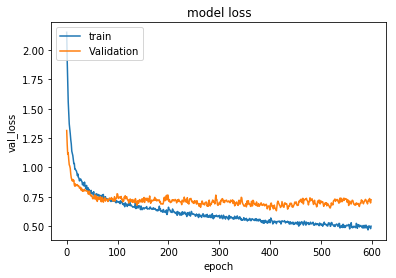

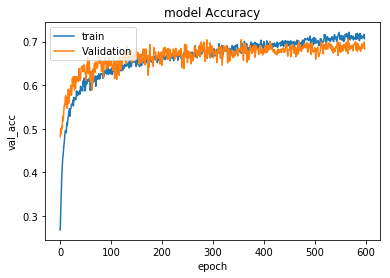

Loading Best Model
0.6376233825333071


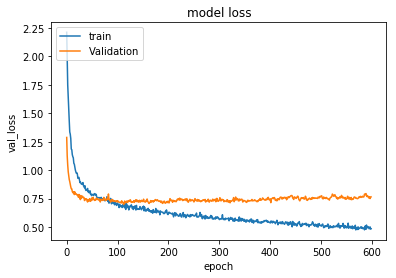

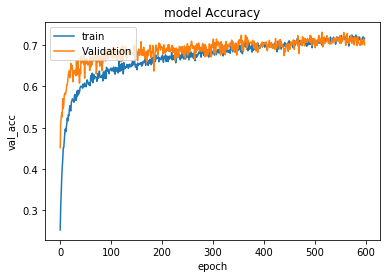

Loading Best Model
0.6991046804917104


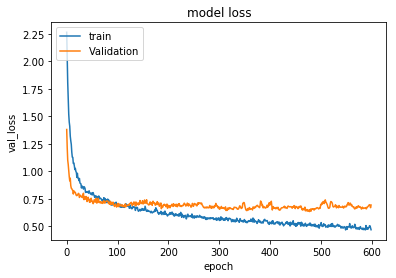

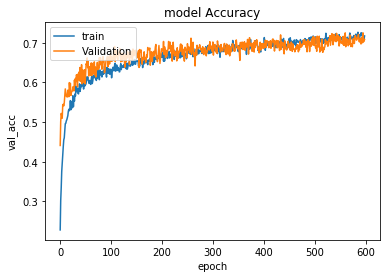

Loading Best Model
0.6183100421648123


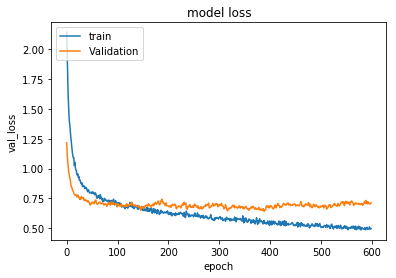

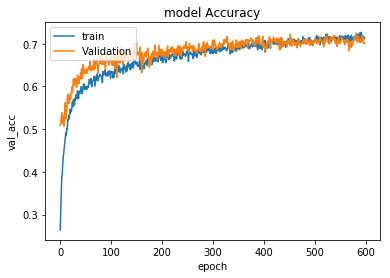

Loading Best Model
0.6441530218841813


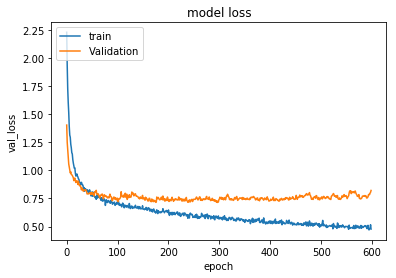

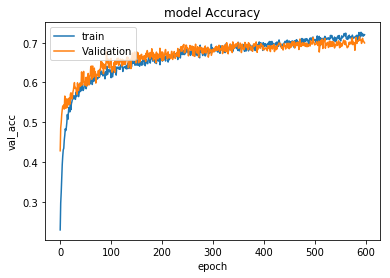

Loading Best Model
0.7290160340263526
MULTI WEIGHTED LOG LOSS : 0.66573 


In [15]:
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 600
batch_size = 100
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.6,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

# Evaluation
features' importance and confusion matrix

In [17]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    unique_y = np.unique(y)
    class_map = dict()
    for i,val in enumerate(unique_y):
        class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])

In [18]:
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [19]:
sample_sub = pd.read_csv('../input/sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

5257

Normalized confusion matrix
[[9.34e-01 0.00e+00 6.62e-03 0.00e+00 0.00e+00 6.62e-03 0.00e+00 0.00e+00
  5.30e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 7.62e-01 0.00e+00 4.24e-02 3.23e-02 0.00e+00 2.83e-02 1.62e-02
  2.02e-03 4.65e-02 4.04e-03 5.45e-02 0.00e+00 1.21e-02]
 [3.25e-03 0.00e+00 9.83e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  6.49e-03 0.00e+00 0.00e+00 0.00e+00 7.58e-03 0.00e+00]
 [0.00e+00 1.12e-01 0.00e+00 3.09e-01 1.27e-01 0.00e+00 1.84e-01 2.93e-02
  0.00e+00 8.47e-02 8.38e-04 1.22e-01 0.00e+00 3.02e-02]
 [0.00e+00 2.19e-02 0.00e+00 8.74e-02 4.32e-01 0.00e+00 1.09e-01 5.46e-03
  0.00e+00 1.09e-01 0.00e+00 2.35e-01 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 6.20e-03 0.00e+00 8.26e-02 6.61e-02 0.00e+00 5.37e-01 7.85e-02
  0.00e+00 1.69e-01 0.00e+00 4.13e-02 0.00e+00 1.86e-02]
 [0.00e+00 1.96e-02 0.00e+00 9.80e-03 0.00e+00 0.00e+00

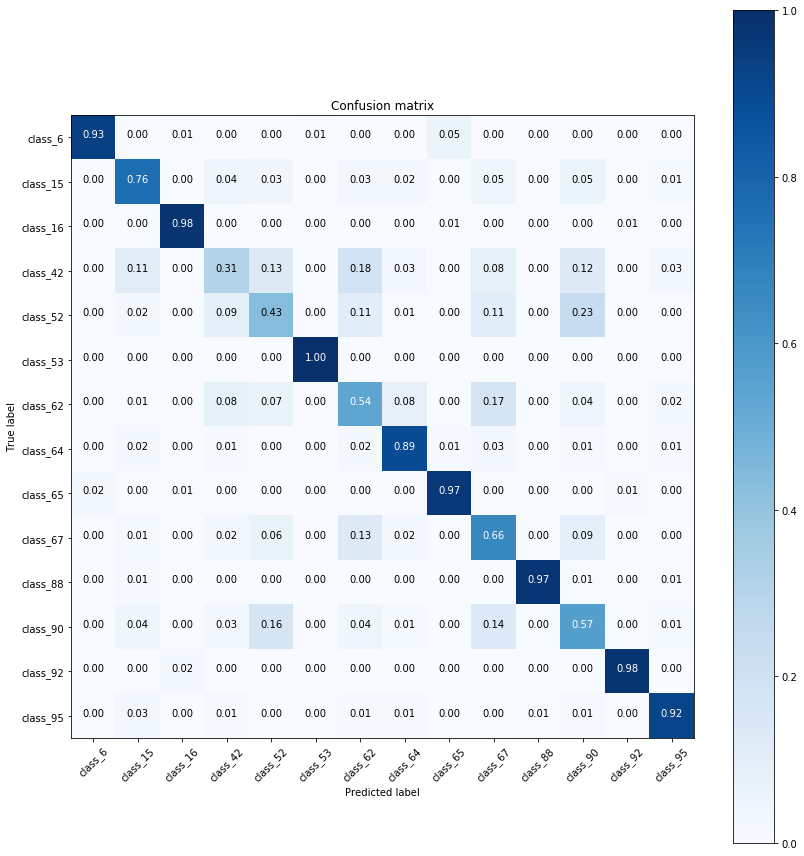

In [20]:
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

# Test Set Predictions

In [ ]:
meta_test = pd.read_csv('../input/test_set_metadata.csv')
meta_test=add_feat(meta_test)

import time

start = time.time()
chunks = 5000000
for i_c, df in enumerate(pd.read_csv('../input/test_set.csv', chunksize=chunks, iterator=True)):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # Group by object id
#     agg_test = df.groupby('object_id').agg(aggs)
#     agg_test.columns = new_columns
#     agg_test['mjd_diff'] = agg_test['mjd_max'] - agg_test['mjd_min']
#     agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
#     agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
#     agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
#     agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']

#     del agg_test['mjd_max'], agg_test['mjd_min']
    agg_test = featurize(df)
    del df
    
    gc.collect()
    
    # Merge with meta data
    full_test = agg_test.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    
    full_test=add_new(full_test)
    full_test[full_train.columns] =full_test[full_train.columns] .replace([np.inf, -np.inf],np.nan)
    full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)
    full_test_ss = ss.transform(full_test[full_train.columns])
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test_ss) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test_ss) / folds.n_splits
    
   # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=class_names)
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.18 * preds_99 / np.mean(preds_99) 
    
    if i_c == 0:
        preds_df.to_csv('predictions.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('predictions.csv',  header=False, mode='a', index=False)
        
    del agg_test, full_test, preds_df, preds
#     print('done')
    if (i_c + 1) % 10 == 0:
        print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))

In [ ]:
z = pd.read_csv('predictions.csv')

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z.to_csv('single_predictions5.csv', index=True)